In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation,concatenate,Bidirectional,BatchNormalization, Lambda, Layer
from keras.initializers import Constant
import keras.backend as K
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [31]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


In [32]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [33]:
data = pd.read_csv("./dataset/dataset.csv")
print(data.head())

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


In [34]:
full_Pers_list = {'INFP' :0 ,'INTJ' :1 ,'INFJ' :2, 'INTP' :3 ,'ENFP' :4 ,'ENTJ' :5, 'ENTP' :6 ,'ENFJ' :7, 'ISFJ' :8 ,'ISFP' :9 ,'ISTJ' :10 ,'ISTP' :11 ,'ESFJ' :12,'ESFP' :13 ,'ESTJ' :14 ,'ESTP' :15}
def type_to_16(typeList):
    labels=[]
    for t in typeList:
        labels.append(full_Pers_list[t])
    return(labels)

def type16_to_vector_label(data):
    for i,label in enumerate(data):
        translation=np.zeros((16))
        translation[int(label)]=1
        data[i]=translation
        
labels=type_to_16(data["type"])
data["labels"]=labels
data.tail()

,type,posts,labels
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,9
8671,ENFP,'So...if this thread already exists someplace ...,4
8672,INTP,'So many questions when i do these things. I ...,3
8673,INFP,'I am very conflicted right now when it comes ...,0
8674,INFP,'It has been too long since I have been on per...,0


In [35]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

In [36]:
# We want to remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]


# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments using regular expressions
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")
        ##### Remove single-charactered words that remain from the cleaning
        words=temp.split()
        finalTemp=""
        for word in words:
            if(len(word)>1):
                finalTemp=finalTemp+" "+word
        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(finalTemp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

In [37]:
list_posts, list_personality  = pre_process_data(data, remove_stop_words=True)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [38]:
print(list_posts[1])
print(list_personality[1])
print(data["labels"][1])

 finding lack post alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough giving new meaning game theory hello grin take converse flirting acknowledge presence return word smooth wordplay cheeky grin lack balance hand eye coordination real iq test score internet iq test funny score higher like former response thread mention believe iq test banish know vanish site year half return find people still commenting post liking idea thought know think thing sometimes go old sherlock holmes quote perhaps man special knowledge special power like rather encourages seek complex cheshirewolf tumblr com post really never thought real function judge use use ne ti dominates fe emotion rarely si also use ni due strength know though ingenious saying really want try see happens playing first person shooter back drive around want see look rock paper one best make lol guy lucky really high tumblr system hear new first person shooter game rocking

In [39]:
#returns the max word numbers 
def max_post_words(posts):
    maxLen=0
    averageLen=0
    for post in posts:
        words=post.split()
        averageLen=averageLen+len(words)
        if maxLen < len(words):
            maxLen=len(words)
    averageLen=int(averageLen/len(posts))
    return maxLen,averageLen
print(list_posts.shape)
print(list_personality.shape)
maxlength,averagelen=max_post_words(list_posts)
print(maxlength)
print(averagelen)

(8675,)
(8675, 4)
883
585


In [40]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./dataset/glove.6B/glove.6B.50d.txt')

In [41]:
print(word_to_index["finding"])
print(index_to_word[148433])
print(word_to_vec_map["finding"])

148433
finding
[ 1.0427    -0.0063726  0.14249   -0.20253    0.81903    0.45835
 -0.53618    0.4273     0.87353    0.36      -0.13102    0.031936
 -0.3458     0.048457   0.53903    0.076773   0.51641   -0.39471
  0.33282   -0.71322   -0.014848   0.5072     0.1407     0.052006
  0.47805   -1.2841    -0.50835    0.040056   0.55624   -0.14598
  2.6381    -0.19551   -0.22558   -1.0202     0.57369    0.20545
 -0.14149    0.44701    0.17831   -0.55761   -0.14858   -0.14687
  0.29202    0.35834    0.22295   -0.12368    0.12302    0.53954
  0.29452   -0.051312 ]


In [42]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   
    X_indices = np.zeros((m,max_len))
    for i in range(m):
        if (i % 500 == 0 or i == 1 or i == m):
            print("%s of %s rows" % (i, m))
        sentence_words =X[i].lower().split()
        j = 0
        for w in sentence_words:
            if j==max_len:
                break
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
            j = j+1
    return X_indices
X=sentences_to_indices(list_posts, word_to_index, averagelen)
print(X.shape)

0 of 8675 rows
1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
(8675, 585)


In [43]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0] 
    
    emb_matrix = np.zeros((vocab_len,emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = Embedding(vocab_len,emb_dim) 
    embedding_layer.build((None,)) 
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [44]:
def multi_loss2(y_true,y_pred):
    return K.mean(K.sum(K.binary_crossentropy(y_true,y_pred)))

In [45]:
def multi_loss(y_true,y_pred):
    return K.exp(K.mean(K.log(K.mean(K.square(y_pred - y_true), axis=0)), axis=-1))

In [46]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [47]:
def personnality_model(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(shape=input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    X = Bidirectional(LSTM(128,return_sequences=False))(embeddings)
    X = Dropout(0.25)(X)
    '''X = LSTM(128,return_sequences=False)(X)
    X = Dropout(0.5)(X)
    Dense(1)(X)
    Activation('sigmoid')(X)
    '''
    X1=Dense(1,name="I/E_classifier")(X)
    X1Output=Activation("sigmoid")(X1)
    
    X2=Dense(1,name="N/S_classifier")(X)
    X2Output=Activation("sigmoid")(X2)
    
    X3=Dense(1,name="F/T_classifier")(X)
    X3Output=Activation("sigmoid")(X3)
    
    X4=Dense(1,name="J/P_classifier")(X)
    X4Output=Activation("sigmoid")(X4)
    
    finalOutput=concatenate(
    inputs=[X1Output,X2Output,X3Output,X4Output],
    name='final_output')
    
    model = model = Model(inputs=sentence_indices, outputs=finalOutput)
    return model

task_list=['I/E_classifier','N/S_classifier','F/T_classifier','J/P_classifier']
model = personnality_model((averagelen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 585)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 585, 50)      20000050    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 256)          183296      embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 256)          0           bidirectional_3[0][0]            
____________________________________________________________________________________________

In [48]:
Y = list_personality
print(Y[0:2])

[[0 0 0 0]
 [1 0 1 1]]


In [49]:
# initializing some hyperparameters
INIT_LR = 0.001
EPOCHS = 10
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=multi_loss2, optimizer=opt, metrics=['binary_accuracy',f1])
(X_train, X_temp, Y_train, Y_temp) = train_test_split(X,Y,test_size=0.2, random_state=42)
(X_valid, X_test, Y_valid, Y_test) = train_test_split(X_temp,Y_temp,test_size=0.5, random_state=42)
history=model.fit(X_train, Y_train,validation_data=(X_valid,Y_valid), batch_size=BS , epochs = EPOCHS, shuffle=True)

Train on 6940 samples, validate on 867 samples
Epoch 1/10
6940/6940 [==============================] - 171s 25ms/step - loss: 74.3140 - binary_accuracy: 0.6932 - f1: 0.5436 - val_loss: 73.0468 - val_binary_accuracy: 0.7042 - val_f1: 0.5128
Epoch 2/10
6940/6940 [==============================] - 167s 24ms/step - loss: 72.9572 - binary_accuracy: 0.7027 - f1: 0.5582 - val_loss: 71.7173 - val_binary_accuracy: 0.7116 - val_f1: 0.5524
Epoch 3/10
6940/6940 [==============================] - 165s 24ms/step - loss: 71.3497 - binary_accuracy: 0.7147 - f1: 0.5769 - val_loss: 71.7670 - val_binary_accuracy: 0.7122 - val_f1: 0.5951
Epoch 4/10
6940/6940 [==============================] - 166s 24ms/step - loss: 69.4153 - binary_accuracy: 0.7298 - f1: 0.6018 - val_loss: 71.7816 - val_binary_accuracy: 0.7186 - val_f1: 0.5523
Epoch 5/10
6940/6940 [==============================] - 166s 24ms/step - loss: 64.3786 - binary_accuracy: 0.7589 - f1: 0.6395 - val_loss: 72.8374 - val_binary_accuracy: 0.7220 - val

In [50]:
test_loss, test_acc,test_f1 = model.evaluate(X_test,Y_test)
print("Accuracy : ",test_acc)
print("F1 Score :",test_f1)
print("Loss :",test_loss)
Yhat=model.predict(X_test[:100])
correct=0
correctlabels=[0,0,0,0]
for i,prediction in enumerate(Yhat):
    for j,value in enumerate(prediction):
        if (value<0.5):
            prediction[j]=0
        else:
            prediction[j]=1
        if(prediction[j]==Y_test[i][j]):
            correctlabels[j]+=1
    if (np.array_equal(prediction,Y_test[i])):
        correct+=1
    print("Prediction :",prediction," Actual Value :",Y_test[i] )
print("Total accuracy : ",correct/100)
print("I/E accuracy : ",correctlabels[0]/100)
print("N/S accuracy : ",correctlabels[1]/100)
print("F/T accuracy : ",correctlabels[2]/100)
print("J/P accuracy : ",correctlabels[3]/100)
print("Binary accuracy :",np.sum(correctlabels)/(4*100))

868/868 [==============================] - 3s 4ms/step
Accuracy :  0.6866359710693359
F1 Score : 0.551786482334137
Loss : 107.44241345313287
Prediction : [1. 0. 1. 1.]  Actual Value : [0 0 1 1]
Prediction : [0. 0. 0. 1.]  Actual Value : [0 0 0 1]
Prediction : [1. 0. 1. 0.]  Actual Value : [0 0 1 1]
Prediction : [0. 0. 1. 1.]  Actual Value : [0 0 0 0]
Prediction : [0. 0. 0. 1.]  Actual Value : [1 0 1 0]
Prediction : [0. 0. 1. 0.]  Actual Value : [0 0 1 1]
Prediction : [0. 0. 0. 1.]  Actual Value : [0 0 0 0]
Prediction : [0. 0. 0. 0.]  Actual Value : [0 0 0 1]
Prediction : [0. 0. 0. 1.]  Actual Value : [0 0 1 1]
Prediction : [0. 0. 0. 1.]  Actual Value : [0 0 0 1]
Prediction : [1. 0. 1. 1.]  Actual Value : [0 0 0 1]
Prediction : [1. 0. 1. 1.]  Actual Value : [0 1 1 1]
Prediction : [0. 0. 1. 1.]  Actual Value : [1 0 1 0]
Prediction : [0. 0. 0. 1.]  Actual Value : [0 1 0 1]
Prediction : [0. 0. 1. 1.]  Actual Value : [1 0 1 1]
Prediction : [0. 0. 0. 1.]  Actual Value : [1 0 1 0]
Prediction 

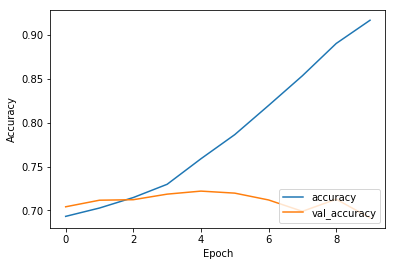

In [53]:
# plotting Accuracy
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

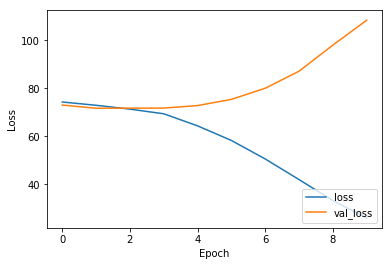

In [54]:
# plotting Losshistory
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')